In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# Make tensorflow not take over the entire GPU memory
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
from tfga import GeometricAlgebra
from tfga.layers import GeometricProductDense, TensorToGeometric, GeometricToTensor

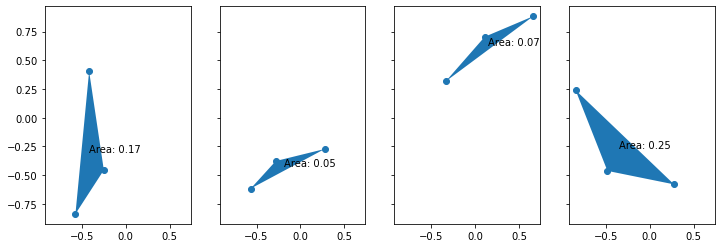

In [2]:
def make_batch(batch_size):
    triangle_points = tf.random.uniform([batch_size, 3, 2], minval=-1, maxval=1)
    x, y = triangle_points[..., 0], triangle_points[..., 1]
    ax, ay, bx, by, cx, cy = x[..., 0], y[..., 0], x[..., 1], y[..., 1], x[..., 2], y[..., 2]
    triangle_areas = 0.5 * tf.abs(ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    return triangle_points, triangle_areas

num_samples = 4
sample_points, sample_areas = make_batch(num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
fig.show()

In [3]:
ga = GeometricAlgebra([1, 1])
s_indices = [0]
v_indices = [1, 2]
mv_indices = tf.range(ga.num_blades)

model = tf.keras.Sequential([
    TensorToGeometric(ga, blade_indices=v_indices),
    GeometricProductDense(
        ga, units=64, activation="relu",
        blade_indices_kernel=mv_indices,
        blade_indices_bias=mv_indices,
    ),
    GeometricProductDense(
        ga, units=64, activation="relu",
        blade_indices_kernel=mv_indices,
        blade_indices_bias=mv_indices,
    ),
    GeometricProductDense(
        ga, units=1,
        blade_indices_kernel=mv_indices,
        blade_indices_bias=s_indices,
    ),
    GeometricToTensor(ga, blade_indices=s_indices)
])

# [B, 3, 2]

print("Samples:", sample_points)
print("Model(Samples):", model(sample_points))

Samples: tf.Tensor(
[[[-0.249856   -0.45557523]
  [-0.573436   -0.83753633]
  [-0.41757035  0.40345407]]

 [[-0.28119326 -0.37714505]
  [-0.5669024  -0.6169205 ]
  [ 0.27422976 -0.27291942]]

 [[ 0.10968089  0.70486164]
  [-0.33639312  0.31570005]
  [ 0.6623955   0.88349605]]

 [[-0.48291063 -0.46281505]
  [ 0.27627826 -0.5803175 ]
  [-0.84552646  0.23987103]]], shape=(4, 3, 2), dtype=float32)
Model(Samples): tf.Tensor(
[[[ 0.00954097]]

 [[-0.01170375]]

 [[ 0.06629146]]

 [[ 0.05017059]]], shape=(4, 1, 1), dtype=float32)


In [4]:
train_points, train_areas = make_batch(1024)
test_points, test_areas = make_batch(128)

model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model.fit(x=train_points, y=train_areas, validation_data=(test_points, test_areas), epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 51ms/step - loss: 0.0606 - mae: 0.1854 - val_loss: 0.0394 - val_mae: 0.1511
Epoch 2/100
32/32 [==============================] - 1s 44ms/step - loss: 0.0378 - mae: 0.1455 - val_loss: 0.0364 - val_mae: 0.1451
Epoch 3/100
32/32 [==============================] - 1s 44ms/step - loss: 0.0330 - mae: 0.1390 - val_loss: 0.0356 - val_mae: 0.1428
Epoch 4/100
32/32 [==============================] - 1s 46ms/step - loss: 0.0299 - mae: 0.1304 - val_loss: 0.0291 - val_mae: 0.1339
Epoch 5/100
32/32 [==============================] - 1s 45ms/step - loss: 0.0247 - mae: 0.1183 - val_loss: 0.0272 - val_mae: 0.1266
Epoch 6/100
32/32 [==============================] - 1s 46ms/step - loss: 0.0203 - mae: 0.1072 - val_loss: 0.0265 - val_mae: 0.1193
Epoch 7/100
32/32 [==============================] - 1s 47ms/step - loss: 0.0172 - mae: 0.0986 - val_loss: 0.0201 - val_mae: 0.1095
Epoch 8/100
32/32 [==============================] - 1s 47ms/step - loss: 0.

In [5]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor_to_geometric (TensorT multiple                  0         
_________________________________________________________________
geometric_product_dense (Geo (4, 64, 4)                1024      
_________________________________________________________________
geometric_product_dense_1 (G (4, 64, 4)                16640     
_________________________________________________________________
geometric_product_dense_2 (G (4, 1, 4)                 257       
_________________________________________________________________
geometric_to_tensor (Geometr (4, 1, 1)                 0         
Total params: 17,921
Trainable params: 17,921
Non-trainable params: 0
_________________________________________________________________
None


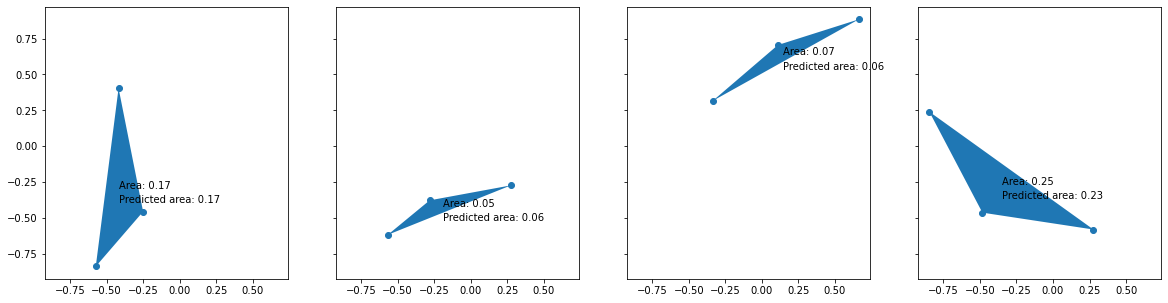

In [6]:
predicted_sample_areas = model(sample_points)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + tf.constant([0, -0.1]))
fig.show()

In [7]:
model_normal = tf.keras.Sequential([
    tf.keras.layers.Dense(64*2, activation="relu"),
    tf.keras.layers.Dense(64*2, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_normal.compile(optimizer="Adam", loss="mse", metrics=["mae"])
model_normal.fit(x=tf.reshape(train_points, [-1, 6]), y=train_areas, validation_data=(tf.reshape(test_points, [-1, 6]), test_areas), epochs=100)

Epoch 1/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0817 - mae: 0.2208 - val_loss: 0.0461 - val_mae: 0.1604
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0469 - mae: 0.1644 - val_loss: 0.0389 - val_mae: 0.1521
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0394 - mae: 0.1475 - val_loss: 0.0365 - val_mae: 0.1443
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0331 - mae: 0.1375 - val_loss: 0.0323 - val_mae: 0.1381
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0291 - mae: 0.1275 - val_loss: 0.0315 - val_mae: 0.1299
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0260 - mae: 0.1204 - val_loss: 0.0282 - val_mae: 0.1263
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0220 - mae: 0.1114 - val_loss: 0.0256 - val_mae: 0.1195
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0197 - m

In [8]:
print(model_normal.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 128)                 896       
_________________________________________________________________
dense_1 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________
None


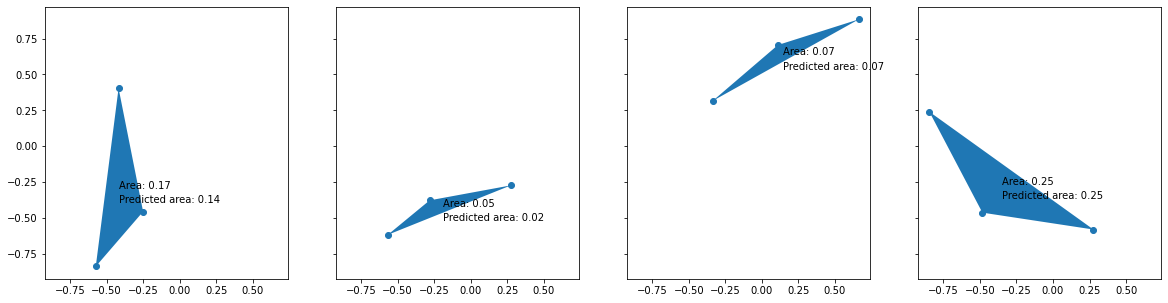

In [9]:
predicted_sample_areas = model_normal(tf.reshape(sample_points, [-1, 6]))

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = tf.reduce_mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + tf.constant([0, -0.1]))
fig.show()